# Importing 2D datasets as materials in Salvus

This notebook will demonstrate how to import 2D data into a Salvus material,
and use it to create a simulation.

## Conforming to structure in wave propagation simulations

Note that this approach, and in general, Salvus, won't conform to whatever
boundaries there are in this spatial dataset. For that, we refer to specialized
software. However, we find that when considering elastic wave behaviour, the
wavelength of the phases determines what is sensed, and thus confrming to grain
boundaries is not important for low frequency signals, whereas for high
frequency signals that do sense grains (or any variation) with more
sensitivity, those are naturally also more accurately meshed due to the
increased mesh resolution at higher frequencies.

To convert a EBSD map to angles, we'll assume the data is coded as **hue** in image data. To covnert RGB values to hue, we'll use OpenCV. However, any way you can get hue data into a XArray DataArray with spatial information will be valid.

In [ ]:
# Install what isn't included in the standard Salvus environment
!pip install opencv-python



Now on to our typical imports:

In [1]:
import pathlib 

import cv2
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from PIL import Image

import salvus.namespace as sn

from salvus.toolbox.helpers.wavefield_output import (
    WavefieldOutput,
    wavefield_output_to_xarray,
)

SITE = "local"
RANKS = 8

--> Server: 'https://l.mondaic.com/licensing_server', User: 'bristol.support', Group: 'UniversityOfBristol'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.44 seconds]


Load the image using PIL and convert it to an RGB numpy array. 

In [2]:
# Load and Display Image

# Load the image using PIL
img = Image.open('./Steel grain map.jpg')

# Convert the image to an RGB numpy array
rgb_img = np.array(img.convert('RGB'))

# Display the shape of the array
print(rgb_img.shape)

(775, 1033, 3)


Convert the RGB image to HSV using OpenCV.

In [3]:
# Convert Image to HSV

# Convert the RGB image to HSV using OpenCV
hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV).astype(np.float32)


Let's now check how the grain orientations are distributed **per pixel** (not per grain).

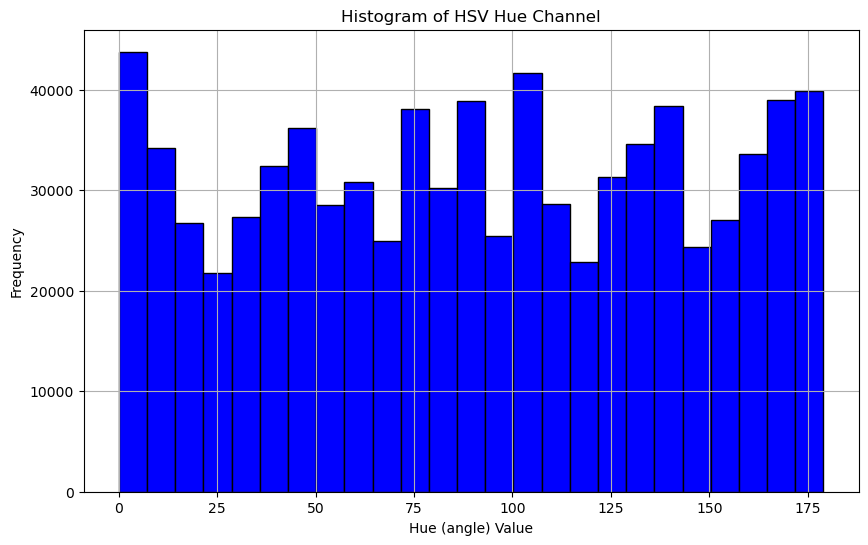

In [4]:
# Plot Histogram of HSV Values

# Plot a histogram of the HSV image's hue channel using matplotlib
plt.figure(figsize=(10, 6))
plt.hist(hsv_img[..., 0].flatten(), bins=25, color='blue', edgecolor='black')
plt.title('Histogram of HSV Hue Channel')
plt.xlabel('Hue (angle) Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
hsv_img.shape


To use spatial data in **SalvusMaterial** it has to have some coordinate
relationship, i.e. we need to know where each pixel goes. I now **assume** that
the image I passed is defined in the domain $[0,1] \times [0,1]$. When you do
this, please check that DataArray construction interprets your data correctly.


Now we create an xarray DataArray for the orientation data using only the hue
values.

In [5]:
orientation_data = xr.DataArray(
    hsv_img[..., 0],  # Use the hue channel from the HSV image
    coords={
        "x": np.linspace(0, 1, hsv_img.shape[0]),  # Create x coordinates
        "y": np.linspace(0, 1, hsv_img.shape[1])   # Create y coordinates
    },
    dims=["x", "y"]  # Define the dimensions
)

# Display the orientation data array
orientation_data

<xarray.DataArray (x: 775, y: 1033)> Size: 3MB
array([[ 56.,  57.,  59., ...,  42.,  43.,  43.],
       [ 55.,  56.,  58., ...,  41.,  42.,  42.],
       [ 53.,  54.,  57., ...,  41.,  41.,  41.],
       ...,
       [ 91.,  91.,  91., ..., 135., 138., 142.],
       [ 91.,  90.,  90., ..., 136., 139., 146.],
       [ 91.,  91.,  91., ..., 138., 142., 150.]], dtype=float32)
Coordinates:
  * x        (x) float64 6kB 0.0 0.001292 0.002584 ... 0.9974 0.9987 1.0
  * y        (y) float64 8kB 0.0 0.000969 0.001938 0.002907 ... 0.9981 0.999 1.0

Plot the orientation data using xarray's plot function.

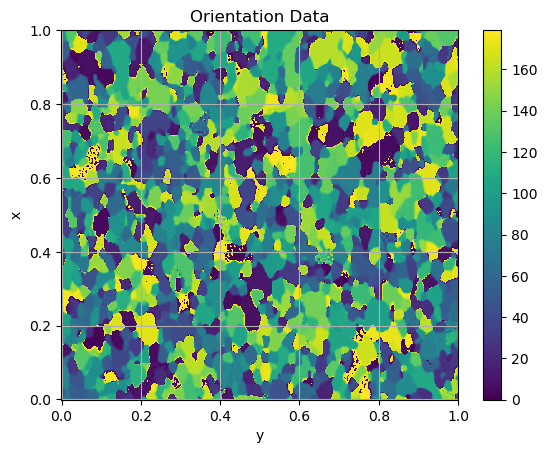

In [6]:
orientation_data.plot()

plt.title('Orientation Data')
plt.grid(True)

In [11]:


def rotation_matrix_y(theta):
    """
    Computes the 3D rotation matrix about the y-axis for a given angle theta.

    Parameters:
    theta (float): Rotation angle in radians.

    Returns:
    numpy.ndarray: 3x3 rotation matrix.
    """
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return np.array([
        [cos_theta,  0, sin_theta],
        [0,          1, 0],
        [-sin_theta, 0, cos_theta]
    ])


def transformation_T(Q):
    """
    Computes the transformation matrix T (6x6) in Voigt notation
    from a 3D rotation matrix Q.

    Parameters:
    Q (numpy.ndarray): 3x3 rotation matrix.

    Returns:
    numpy.ndarray: 6x6 transformation matrix.
    """
    T = np.array([
        [Q[0,0]**2, Q[0,1]**2, Q[0,2]**2, 2*Q[0,1]*Q[0,2], 2*Q[0,0]*Q[0,2], 2*Q[0,0]*Q[0,1]],
        [Q[1,0]**2, Q[1,1]**2, Q[1,2]**2, 2*Q[1,1]*Q[1,2], 2*Q[1,0]*Q[1,2], 2*Q[1,0]*Q[1,1]],
        [Q[2,0]**2, Q[2,1]**2, Q[2,2]**2, 2*Q[2,1]*Q[2,2], 2*Q[2,0]*Q[2,2], 2*Q[2,0]*Q[2,1]],
        [2*Q[1,0]*Q[2,0], 2*Q[1,1]*Q[2,1], 2*Q[1,2]*Q[2,2],
         Q[1,1]*Q[2,2] + Q[1,2]*Q[2,1], Q[1,0]*Q[2,2] + Q[1,2]*Q[2,0], Q[1,0]*Q[2,1] + Q[1,1]*Q[2,0]],
        [2*Q[0,0]*Q[2,0], 2*Q[0,1]*Q[2,1], 2*Q[0,2]*Q[2,2],
         Q[0,1]*Q[2,2] + Q[0,2]*Q[2,1], Q[0,0]*Q[2,2] + Q[0,2]*Q[2,0], Q[0,0]*Q[2,1] + Q[0,1]*Q[2,0]],
        [2*Q[0,0]*Q[1,0], 2*Q[0,1]*Q[1,1], 2*Q[0,2]*Q[1,2],
         Q[0,1]*Q[1,2] + Q[0,2]*Q[1,1], Q[0,0]*Q[1,2] + Q[0,2]*Q[1,0], Q[0,0]*Q[1,1] + Q[0,1]*Q[1,0]],
    ], dtype=float)
    
    S = np.diag([1,1,1,2,2,2])
    return np.linalg.inv(S) @ T @ S



def rotated_elasticityTensor(C, theta):
    """
    Rotates the elasticity tensor C (6x6 in Voigt notation) by angle theta
    about the y-axis.

    Parameters:
    C (numpy.ndarray): 6x6 elasticity tensor in Voigt notation.
    theta (float): Rotation angle in radians.

    Returns:
    numpy.ndarray: Rotated 6x6 elasticity tensor in Voigt notation.
    """
    Q = rotation_matrix_y(theta)  # Compute the rotation matrix
    T = transformation_T(Q)      # Compute the transformation matrix (6x6)
    C_rotated = T @ C @ T.T       # Perform the tensor rotation in Voigt notation
    return np.rint(C_rotated)


  
def TTI_velocity_from_tensor(C, rho):
    """
    Computes velocities (VPV, VPH, VSV, VSH) and ETA (η) from a 3D TTI stiffness tensor.

    Parameters:
    C (numpy.ndarray): 6x6 stiffness tensor in Voigt notation.
    rho (float): Density of the material (kg/m^3).

    Returns:
    dict: Dictionary containing VPV, VPH, VSV, and ETA.
    """
    # Extract relevant stiffness coefficients
    C11 = C[0, 0]  # Horizontal P-wave stiffness
    C33 = C[2, 2]  # Vertical P-wave stiffness
    C44 = C[3, 3]  # Vertical S-wave stiffness
    C55 = C44      # Symmetry assumption: C55 = C44
    C66 = C[5,5]   # Horizontal S-wave stiffness
    C13 = C[0, 2]  # Coupling stiffness

    # Calculate velocities
    VPV = np.sqrt(C33 / rho)  # Vertical P-wave velocity
    VPH = np.sqrt(C11 / rho)  # Horizontal P-wave velocity
    VSV = np.sqrt(C55 / rho)  # Vertical S-wave velocity
    VSH = np.sqrt(C66 / rho)  # Horizontal S-wave velocity

    # Calculate epsilon
    epsilon = (C11 - C33) / (2 * C33)

    # Calculate delta
    delta = ((C13 + C44) ** 2 - (C33 - C44) ** 2) / (2 * C33 * (C33 - C44))

    # Calculate eta
    eta = (epsilon - delta) / (1 + 2 * delta)


    # Return results as a dictionary
    return {
        "RHO": rho,
        "VPV": VPV,
        "VPH": VPH,
        "VSV": VSV,
        "VSH": VSH,
        "ETA": eta
    }
    





class Austenite:
    def __init__(self):
        # Define parameters
        self.RHO = 8100  # Density in kg/m^3
        self.C11 = 217.1e9  # Stiffness in Pa
        self.C13 = 144.4e9  # Stiffness in Pa
        self.C33 = 263.2e9  # Stiffness in Pa
        self.C44 = 82.4e9   # Stiffness in Pa
        self.C66 = 128.4e9  # Stiffness in Pa

        # Derived parameters
        self.C12 = self.C11 - 2 * self.C66  # Derived from the relationship
        self.C22 = self.C11                # Symmetry in TTI media
        self.C23 = self.C13                # Symmetry in TTI media
        self.C55 = self.C44                # Symmetry in TTI media
        
        self.C = self.tensor()  

    

    def density(self):
        return self.RHO

    def tensor(self):
        C = np.zeros((6,6))
        C[0,0] = self.C11
        C[0,1] = self.C12
        C[0,2] = self.C13
        C[1,1] = self.C22
        C[1,2] = self.C23
        C[2,2] = self.C33
        C[3,3] = self.C44
        C[4,4] = self.C55
        C[5,5] = self.C66
        
        M = C + C.T                 # sum (not average)
        di = np.diag_indices_from(M)
        M[di] *= 0.5                # halve only the diagonal
        return M    
    
    
    def rotated_tensor(self, theta):
        return rotated_elasticityTensor(self.tensor(), theta)
        
    def rotated_VTI_approx(self, theta):
        rotated_C = self.rotated_tensor(theta)
        params = {
            "rho": self.RHO, 
            "c11": rotated_C[0, 0],
            "c12": rotated_C[0, 0] - 2 * rotated_C[5, 5],
            "c13": rotated_C[0, 2],
            "c14": 0,
            "c15": 0,
            "c16": 0,
            "c22": rotated_C[0, 0],
            "c23": rotated_C[0, 2],
            "c24": 0,
            "c25": 0,
            "c26": 0,
            "c33": rotated_C[2, 2],
            "c34": 0,
            "c35": 0,
            "c36": 0,
            "c44": rotated_C[3, 3],
            "c45": 0,
            "c46": 0.0,
            "c55": rotated_C[3, 3],
            "c56": 0,
            "c66": rotated_C[5, 5],
        }
        return params

    def VTI_parameters(self):
        return {
        "rho": self.RHO, 
        "c11": self.C11,
        "c12": self.C12,
        "c13": self.C13,
        "c33": self.C33,
        "c44": self.C44,
        }
    
    def rotated_parameters(self, theta):
        rotated_C = self.rotated_tensor(theta)
        return {
        "rho": self.RHO, 
        "c11": rotated_C[0, 0],
        "c12": rotated_C[0, 1],
        "c13": rotated_C[0, 2],
        "c14": rotated_C[0, 3],
        "c15": rotated_C[0, 4],
        "c16": rotated_C[0, 5],
        "c22": rotated_C[1, 1],
        "c23": rotated_C[1, 2],
        "c24": rotated_C[1, 3],
        "c25": rotated_C[1, 4],
        "c26": rotated_C[1, 5],
        "c33": rotated_C[2, 2],
        "c34": rotated_C[2, 3],
        "c35": rotated_C[2, 4],
        "c36": rotated_C[2, 5],
        "c44": rotated_C[3, 3],
        "c45": rotated_C[3, 4],
        "c46": rotated_C[3, 5],
        "c55": rotated_C[4, 4],
        "c56": rotated_C[4, 5],
        "c66": rotated_C[5, 5],
        }




In [12]:
matl = Austenite()
matl.rotated_parameters(0)

{'rho': 8100,
 'c11': 217100000000.0,
 'c12': -39700000000.0,
 'c13': 144400000000.0,
 'c14': 0.0,
 'c15': 0.0,
 'c16': 0.0,
 'c22': 217100000000.0,
 'c23': 144400000000.0,
 'c24': 0.0,
 'c25': 0.0,
 'c26': 0.0,
 'c33': 263200000000.0,
 'c34': 0.0,
 'c35': 0.0,
 'c36': 0.0,
 'c44': 82400000000.0,
 'c45': 0.0,
 'c46': 0.0,
 'c55': 82400000000.0,
 'c56': 0.0,
 'c66': 128400000000.0}

In [13]:
RHO = 8100  # Density in kg/m^3
C11 = 217.1e9  # Stiffness in Pa
C13 = 144.4e9  # Stiffness in Pa
C33 = 263.2e9  # Stiffness in Pa
C44 = 82.4e9   # Stiffness in Pa

C66 = 128.4e9  # Stiffness in Pa

C12 = C11 - 2 * C66

matl_hex = sn.material.from_params(rho=RHO, c11=C11, c12=C12, c13=C13, c33=C33, c44=C44)


In [19]:
matl_hex = sn.material.from_params(**matl.VTI_parameters())
matl_hex

salvus.material.elastic.hexagonal.TensorComponents

In [20]:
matl_ort = sn.material.elastic.triclinic.TensorComponents.from_material(matl_hex)
matl_ort 


Field,Type,Value (or range)
RHO,constant,8.1e+03
C11,constant,2.2e+11
C12,constant,-4e+10
C13,constant,1.4e+11
C14,constant,0
C15,constant,0
C16,constant,0
C22,constant,2.2e+11
C23,constant,1.4e+11
C24,constant,0


salvus.material.elastic.triclinic.TensorComponents

## Creating materials from datasets

The canonical way to create a material for a simulation via **SalvusMaterial**
would be to create materials with homogeneous parameters. However, this
interface also allows spatial variations via DataArray's (as well as a few
other approaches not discussed here: analytic parameters and array parameters).

This is exactly what we need to create a material that varies spatially. However, we only have one parameter that varies spatially (grain orientation), while the stiffness properties themselves are homogenous. We can still pass the homogeneous parameters as single numbers, while only the orientation is spatially varying.

In [21]:
orientation_of_grains = sn.material.orientation.ClockwiseAngle.from_params(angle_in_degrees=orientation_data)


In [22]:
# Define Material Properties

# Define the orientation of grains using salvus
orientation_of_grains = sn.material.orientation.ClockwiseAngle.from_params(angle_in_degrees=orientation_data)

material_unoriented = sn.material.elastic.hexagonal.TensorComponents.from_material(matl_hex)


# # Define the unoriented material properties using salvus
# material_unoriented = sn.material.elastic.hexagonal.Velocity.from_params(
#     rho=8100,  # Density in kg/m^3
#     eta=-0.20414567258641442,   # Anisotropy parameter
#     vpv=5700.33570594696,  # P-wave velocity in the vertical direction in m/s
#     vph=5177.110114320775,  # P-wave velocity in the horizontal direction in m/s
#     vsv=3189.4889098682943,  # S-wave velocity in the vertical direction in m/s
#     vsh=3981.438414926426   # S-wave velocity in the horizontal direction in m/s
# )

# Apply the orientation to the material properties
material_oriented = matl_hex.with_orientation(orientation_of_grains)


material_oriented.ds

<xarray.Dataset> Size: 42MB
Dimensions:           (x: 775, y: 1033)
Coordinates:
  * x                 (x) float64 6kB 0.0 0.001292 0.002584 ... 0.9987 1.0
  * y                 (y) float64 8kB 0.0 0.000969 0.001938 ... 0.9981 0.999 1.0
Data variables:
    RHO               (x, y) float64 6MB 8.1e+03 8.1e+03 ... 8.1e+03 8.1e+03
    C11               (x, y) float64 6MB 2.171e+11 2.171e+11 ... 2.171e+11
    C12               (x, y) float64 6MB -3.97e+10 -3.97e+10 ... -3.97e+10
    C13               (x, y) float64 6MB 1.444e+11 1.444e+11 ... 1.444e+11
    C33               (x, y) float64 6MB 2.632e+11 2.632e+11 ... 2.632e+11
    C44               (x, y) float64 6MB 8.24e+10 8.24e+10 ... 8.24e+10 8.24e+10
    ANGLE_IN_DEGREES  (x, y) float32 3MB 56.0 57.0 59.0 ... 138.0 142.0 150.0

In [23]:
material_unoriented

salvus.material.elastic.hexagonal.TensorComponents

When we look at the output above, we see that each grain still has the same elastic tensor, if not considering the orientation. However, due to their orientation, the hexagonal elastic tensors are rotated s.t. every grain becomes triclinic in the global coordinate system.

When dispatching this simulation, we need to convert the material so that it's rotations are all applied:

In [24]:

# Import additional material details from salvus
from salvus.material._details import material as md


# Convert the oriented material to solver form for 2D simulations
material1 = md.to_solver_form(material_oriented, ndim=2)

# Define a default orientation for comparison
orientation_of_grains_default = sn.material.orientation.ClockwiseAngle.from_params(angle_in_degrees=0)

# Convert the unoriented material with default orientation to solver form for 2D simulations
material2 = md.to_solver_form(material_unoriented.with_orientation(orientation_of_grains_default), ndim=2)

material1

Field,Type,Value (or range)
RHO,discrete,8.1e+03 to 8.1e+03
C11,discrete,2.2e+11 to 2.8e+11
C12,discrete,1.1e+11 to 1.4e+11
C13,discrete,-2.6e+10 to 2.6e+10
C22,discrete,2.2e+11 to 2.8e+11
C23,discrete,-2.6e+10 to 2.6e+10
C33,discrete,4.8e+10 to 8.2e+10


salvus.material.elastic.hexagonal._TensorComponents2D

This actually shows how now even entries that are not part of the original hexagonal tensor are non-zero.

## Creating meshes from materials
Define the simulation domain and mesh resolution using salvus.

In [34]:
# Define Simulation Domain and Mesh Resolution

# Unnecessary, but could be used to combine materials:
# layered_model1 = sn.layered_meshing.LayeredModel([material1])
# layered_model2 = sn.layered_meshing.LayeredModel([material2])


# Define the simulation domain using salvus
domain = sn.domain.dim2.BoxDomain.from_bounds(0.02, 0.02)

# Define the central frequency for the simulation
central_frequency = 1e6


import salvus.mesh.layered_meshing as lm
import salvus


# acoustic material
homogeneous_model = lm.LayeredModel(
    [
        material2,
    ] 
)


homogeneous_model_ab = sn.layered_meshing.MeshingProtocol(
    homogeneous_model,
    ab=salvus.mesh.simple_mesh.basic_mesh.AbsorbingBoundaryParameters(
        free_surface=False,
        number_of_wavelengths=1.5,
        reference_velocity=5000,
        reference_frequency=central_frequency * 2,
    ),
)

mesh_homogeneous = lm.mesh_from_domain(
    domain=domain,
    model=homogeneous_model_ab,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=central_frequency * 2, elements_per_wavelength=3
    ),
)





# # Define the mesh resolution using salvus
# mesh_resolution = sn.MeshResolution(
#     reference_frequency=central_frequency * 2,  # Reference frequency for the mesh
#     elements_per_wavelength=1.5,  # Number of elements per wavelength
#     model_order=2  # Model order for the mesh
# )

# # Create the mesh for the grains model using the defined domain and mesh resolution
# mesh_grains = sn.layered_meshing.mesh_from_domain(
#     domain=domain,
#     model=material1,
#     mesh_resolution=mesh_resolution
# )


# # Create the mesh for the no grains model using the defined domain and mesh resolution
# mesh_no_grains = sn.layered_meshing.mesh_from_domain(
#     domain=domain,
#     model=material2,
#     mesh_resolution=mesh_resolution
# )


# # Display one of the created meshes
# mesh_grains


mesh_homogeneous

In [37]:
x0, x1 = 0.0, 0.02
y0, y1 = 0.0, 0.02
source_r = 9e-3
center = np.array([x1/2, y1/2])
n_txs =16


def locate_source_in_mesh(n_txs, center, radius):
    angles_deg = np.linspace(0, 360, n_txs + 1)[:-1]  
    angles_rad = np.deg2rad(angles_deg)
    x = np.cos(angles_rad)
    y = np.sin(angles_rad)
    nomal_vec = np.round(np.stack((x, y), axis=1), 6)
    tx_coordinates = nomal_vec * radius + center

    mesh_nodes = mesh_homogeneous.get_element_nodes().reshape(-1, 2)
    unique_mesh_nodes = np.unique(mesh_nodes, axis=0)

    closest_node = np.array([
        unique_mesh_nodes[np.argmin(np.linalg.norm(unique_mesh_nodes - tx, axis=1))]
        for tx in tx_coordinates
    ])
    return tx_coordinates, nomal_vec

# Generate txs and txs
# number of sources
tx_coordinates, nomal_vec = locate_source_in_mesh(n_txs=n_txs, center = center,radius=source_r)
mag_ratio = 1e12
sources = [
    sn.simple_config.source.cartesian.VectorPoint2D(
        x=tx[0], y=tx[1], 
        fx=nomal_vec[_i,0]*mag_ratio, fy=nomal_vec[_i,1]*mag_ratio
        ) 

    for _i, tx in enumerate(tx_coordinates)
] 


n_rxs = 32

rx_coordinates, _ = locate_source_in_mesh(n_txs=n_rxs, center = center,radius=source_r)
fileds = ["displacement"]

events = []


for _i, src in enumerate(sources): 
    receivers = [
    sn.simple_config.receiver.cartesian.Point2D(
        x=rx[0], y=rx[1], 
        fields=fileds, station_code=f"{_i:06d}",
        ) 
    for _i, rx in enumerate(rx_coordinates) if  np.linalg.norm(src.location - rx) > source_r / 2

]
    
    events.append(sn.Event(event_name=f"event_{_i}", sources=src, receivers=receivers))


In [38]:
project_name = "project_EBSD_grain_test"

p = sn.Project.from_domain(project_name, domain=domain, load_if_exists=True)

Accordion()

In [40]:
stf = sn.simple_config.stf.Ricker(center_frequency=central_frequency)
time_ratio = 3
end_time = 2e-6 * time_ratio

sim_config = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_homogeneous,
    name="mesh_homogeneous",
    # Event specific configuration.
    event_configuration=sn.EventConfiguration(
        # Source wavelet.
        wavelet=stf,
        waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
            end_time_in_seconds=end_time,
            time_step_in_seconds=1/(central_frequency *100)
        ),
    ),
)

# add simulation configuration to Project
p.add_to_project(
    sim_config, overwrite=True
    )


def add_events_to_Project(Project, events):
    for event in events:
        Project.add_to_project(event)
    return None
add_events_to_Project(p, events)




[2025-10-01 11:57:52,712] INFO: Deleting existing `mesh_homogeneous` entity of type `simulation_configuration` ...


In [41]:
p.viz.nb.simulation_setup(
    simulation_configuration='mesh_homogeneous',
    events=p.events.list(),
)

In [42]:

p.simulations.launch(
    simulation_configuration="mesh_homogeneous",
    events=p.events.list(),
    site_name='oliver_wsl',
    ranks_per_job=RANKS,
)

p.simulations.query(block=True)


[2025-10-01 11:58:36,920] INFO: Submitting job array with 16 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|          | 0/16 [00:00<?, ?job/s]

VBox()

RuntimeError: Querying process 7544 failed with exit code 1.
stderr: 

stdout: 
your 131072x1 screen size is bogus. expect trouble

In [ ]:
orientation_data.plot()

plt.title('Orientation Data')
plt.grid(True)

## Creating simulations
Define simulation configurations for the meshes with and without grains.

In [30]:
end_time = 0.00025
time_step_in_seconds=1.8e-07

stf = sn.simple_config.stf.Ricker(center_frequency=central_frequency)
event_configuration=sn.EventConfiguration(
        wavelet=stf,
        waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
            time_step_in_seconds=time_step_in_seconds,
            end_time_in_seconds=end_time
        ),
    )



# p += sn.UnstructuredMeshSimulationConfiguration(
#     unstructured_mesh=mesh_grains,
#     name="sc_mesh_grains",
#     event_configuration=event_configuration,
# )


# Define the simulation configuration for the mesh without grains
p += sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_homogeneous,
    name="sc_mesh_no_grains",
event_configuration=event_configuration,
)


In [31]:
# Add Event to Project

# Define the source location and force components using salvus
source = sn.simple_config.source.cartesian.VectorPoint2D(x=0.5, y=0.5, fx=0, fy=1.0)

# Create an event with the defined source
p += sn.Event(
    event_name="event_1",  # Name of the event
    sources=source  # Source configuration
)

In [32]:
# Launch the simulation for the mesh with and without grains
for sim in p.simulations.list():
    p.simulations.launch(
        simulation_configuration=sim, 
        events="event_1",   
        site_name='oliver_wsl', 
        ranks_per_job=RANKS,
        delete_conflicting_previous_results=True,
        extra_output_configuration={
            "volume_data": {
                "sampling_interval_in_time_steps": int(end_time/time_step_in_seconds/2), 
                "fields": ["displacement"],  
            },
        }
    )

    p.simulations.query(block=True)


[2025-10-01 11:51:50,924] INFO: Submitting job ...
Uploading 1 files...

🚀  Submitted job_2510011151016145_5bdbc4626c@oliver_wsl


VBox()

In [ ]:
def vector_norm(x, dim, ord=None):
    """
    Vector norm for XArray.
    """
    return xr.apply_ufunc(
        np.linalg.norm, x, input_core_dims=[[dim]], kwargs={"ord": ord, "axis": -1}
    )



In [ ]:

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i, sim in enumerate(p.simulations.list()):
    output_file = pathlib.Path(
        p.simulations.get_simulation_output_directory(
            sim, "event_1"
        ),
        "volume_data_output.h5",
    ).resolve()

    displacement = WavefieldOutput.from_file(output_file,
                            field="displacement",
                            output_type="volume")


    resolution = 200
    wavefields_as_xarray = wavefield_output_to_xarray(
        displacement,
        [
            np.linspace(0.0, 1.0, resolution),
            np.linspace(0.0, 1.0, resolution),
        ],
    ).T

    wavefield_data = vector_norm(
        wavefields_as_xarray, dim="c"
    ).sel(
        t=end_time, method="nearest"
    )
    wavefield_normalized = wavefield_data / np.max(np.abs(wavefield_data))


    if sim == "sc_mesh_grains":
        axs[i].imshow(orientation_data / orientation_data.max(), cmap='gray', extent=[0, 1, 0, 1], alpha=0.4)
        axs[i].set_title('Displacement magnitude in hexagonal\nmaterial with grain orientation')
    else:
        axs[i].set_title('Displacement magnitude in hexagonal\nmaterial without any orientation')


    wavefield_colormap = axs[i].imshow(wavefield_normalized, cmap='Reds', alpha=wavefield_normalized/2 + 0.5, vmax=0.25, extent=[0, 1, 0, 1])

    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')

# Show the plot
plt.tight_layout() 
plt.show()

Seems like effectively, randomly oriented grains behave isotropically on a
macro scale.